In [23]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset


## $$
\begin{aligned}
  \dot{x} = \alpha x - \beta xy \\
  \dot{y} =  \gamma xy - \delta y 
\end{aligned}
$$


In [252]:
function LV(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1]
    du[2] = γ*u[1]*u[2]  - δ*u[2]
end


p_ = Float32[1.3, 0.9, 0.8, 1.8]


# Define the experimental parameter

tspan = (0.0f0,3.0f0)
u0 = Float32[0.44249296,4.6280594]
p_ = Float32[1.3, 0.9, 0.8, 1.8]

prob = ODEProblem(LV, u0, tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-3)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training dataset

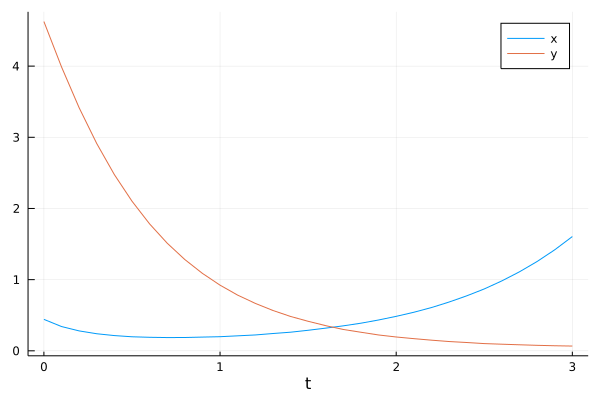

In [253]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(solution.t, Xₙ[1, :], xlabel = "t", label = "x")
plot!(solution.t, Xₙ[2, :], label = "y")

## UADE

In [254]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = 0.1);

## Plot the untrained solution

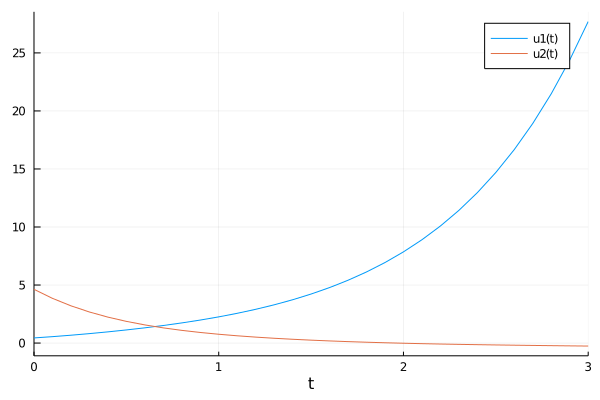

In [255]:
plot(sol_nn, xlabel = "t")
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [256]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [257]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 300)

loss: 26.6:   3%|██                                     |  ETA: 0:01:34

Current loss after 10 iterations: 26.552738


loss: 16.1:   7%|███                                    |  ETA: 0:01:20

Current loss after 20 iterations: 16.111233


loss: 14.1:  10%|████                                   |  ETA: 0:01:13

Current loss after 30 iterations: 14.119774


loss: 12.4:  13%|██████                                 |  ETA: 0:01:08

Current loss after 40 iterations: 12.437652


loss: 10.8:  17%|███████                                |  ETA: 0:01:05

Current loss after 50 iterations: 10.8222065


loss: 9.35:  20%|████████                               |  ETA: 0:01:03

Current loss after 60 iterations: 9.351002


loss: 8.1:  23%|██████████                              |  ETA: 0:01:01

Current loss after 70 iterations: 8.0977125


loss: 7.1:  27%|███████████                             |  ETA: 0:00:59

Current loss after 80 iterations: 7.095788


loss: 6.33:  30%|████████████                           |  ETA: 0:00:56

Current loss after 90 iterations: 6.3309255


loss: 5.75:  33%|█████████████                          |  ETA: 0:00:53

Current loss after 100 iterations: 5.747329


loss: 5.27:  37%|███████████████                        |  ETA: 0:00:50

Current loss after 110 iterations: 5.2721496


loss: 4.85:  40%|████████████████                       |  ETA: 0:00:48

Current loss after 120 iterations: 4.8461156


loss: 4.44:  43%|█████████████████                      |  ETA: 0:00:45

Current loss after 130 iterations: 4.438121


loss: 4.04:  47%|███████████████████                    |  ETA: 0:00:43

Current loss after 140 iterations: 4.0389266


loss: 3.65:  50%|████████████████████                   |  ETA: 0:00:40

Current loss after 150 iterations: 3.6491249


loss: 3.27:  53%|█████████████████████                  |  ETA: 0:00:37

Current loss after 160 iterations: 3.2722108


loss: 2.91:  57%|███████████████████████                |  ETA: 0:00:35

Current loss after 170 iterations: 2.912878


loss: 2.58:  60%|████████████████████████               |  ETA: 0:00:32

Current loss after 180 iterations: 2.5763903


loss: 2.27:  63%|█████████████████████████              |  ETA: 0:00:29

Current loss after 190 iterations: 2.268249


loss: 1.99:  67%|██████████████████████████             |  ETA: 0:00:27

Current loss after 200 iterations: 1.9935085


loss: 1.76:  70%|████████████████████████████           |  ETA: 0:00:24

Current loss after 210 iterations: 1.7560545


loss: 1.56:  73%|█████████████████████████████          |  ETA: 0:00:21

Current loss after 220 iterations: 1.55792


loss: 1.4:  77%|███████████████████████████████         |  ETA: 0:00:19

Current loss after 230 iterations: 1.3986597


loss: 1.28:  80%|████████████████████████████████       |  ETA: 0:00:16

Current loss after 240 iterations: 1.2753577


loss: 1.18:  83%|█████████████████████████████████      |  ETA: 0:00:14

Current loss after 250 iterations: 1.182965


loss: 1.12:  87%|██████████████████████████████████     |  ETA: 0:00:11

Current loss after 260 iterations: 1.1152577


loss: 1.07:  90%|████████████████████████████████████   |  ETA: 0:00:08

Current loss after 270 iterations: 1.0658572


loss: 1.03:  93%|█████████████████████████████████████  |  ETA: 0:00:05

Current loss after 280 iterations: 1.029096


loss: 1:  97%|█████████████████████████████████████████ |  ETA: 0:00:03

Current loss after 290 iterations: 1.0005105


loss: 0.977: 100%|██████████████████████████████████████| Time: 0:01:19


Current loss after 300 iterations: 0.97688776


 * Status: success

 * Candidate solution
    Final objective value:     9.768878e-01

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   86  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


## Training with BFGS

In [258]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)

Current loss after 310 iterations: 0.11160626
Current loss after 320 iterations: 0.05704522
Current loss after 330 iterations: 0.02279794
Current loss after 340 iterations: 0.01779143
Current loss after 350 iterations: 0.0101716705
Current loss after 360 iterations: 0.0058120512
Current loss after 370 iterations: 0.0035653533
Current loss after 380 iterations: 0.002881422
Current loss after 390 iterations: 0.0022356987
Current loss after 400 iterations: 0.0018418259
Current loss after 410 iterations: 0.0015549391
Current loss after 420 iterations: 0.0014344361
Current loss after 430 iterations: 0.00096121826
Current loss after 440 iterations: 0.0007719026
Current loss after 450 iterations: 0.00062278035
Current loss after 460 iterations: 0.0005370697
Current loss after 470 iterations: 0.00042904052
Current loss after 480 iterations: 0.00041191274
Current loss after 490 iterations: 0.00031280975
Current loss after 500 iterations: 0.00027201313
Current loss after 510 iterations: 0.000247

 * Status: success

 * Candidate solution
    Final objective value:     1.675572e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.91e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.64e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.88e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   117  (vs limit Inf)
    Iterations:    280
    f(x) calls:    1023
    ∇f(x) calls:   1023


## Plot the loss

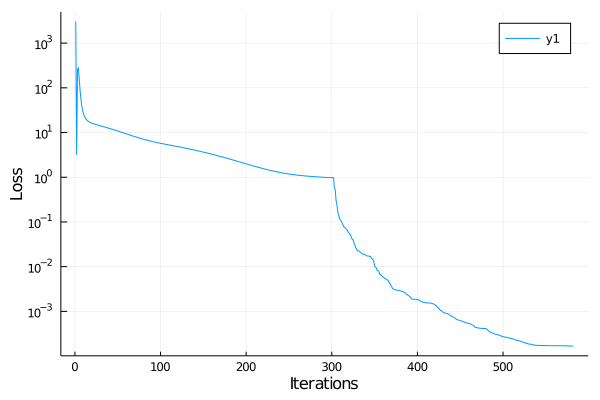

In [259]:
plot(losses, yaxis=:log, xlabel = "Iterations", ylabel = "Loss")

## Plot the approximation and the original data

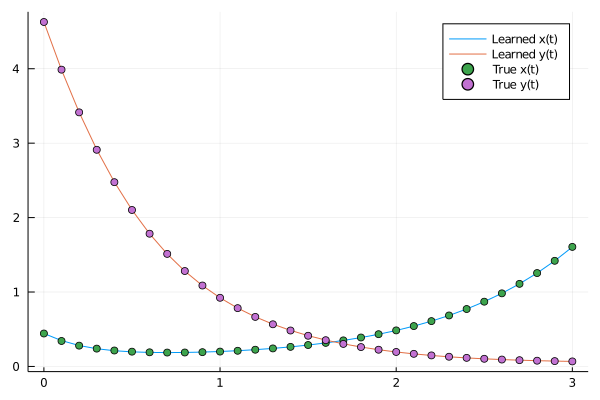

In [260]:
# Plot the data and the approximation
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [261]:
function dudt2_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
tspan2 = (0.0f0, 10.0f0)
prob_nn2 = ODEProblem(dudt2_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.1);

## Test the prediction

In [262]:
tspan_test = (0.0f0, 5.0f0)
prob_test = ODEProblem(LV, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), saveat = 0.05);

## Plot Toghether True And Prediction
### Phase Space Plot

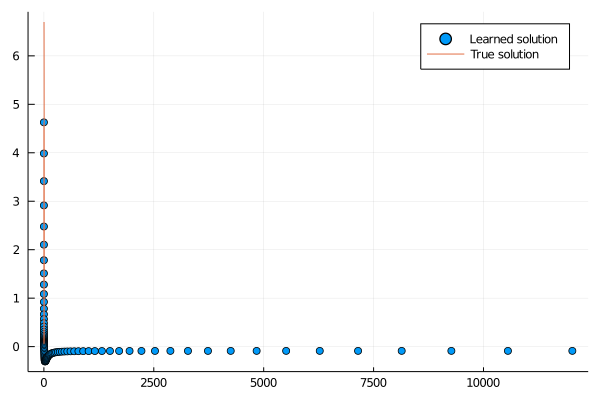

In [263]:
#scatter(Array(solution_test)[1, :], Array(solution_test)[2, :])
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], label = "Learned solution")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "True solution")

## Plot $x(t)$ and $y(t)$

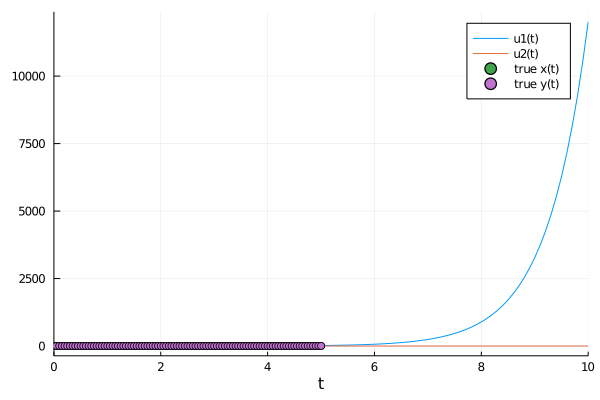

In [264]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x(t)")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true y(t)")

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives

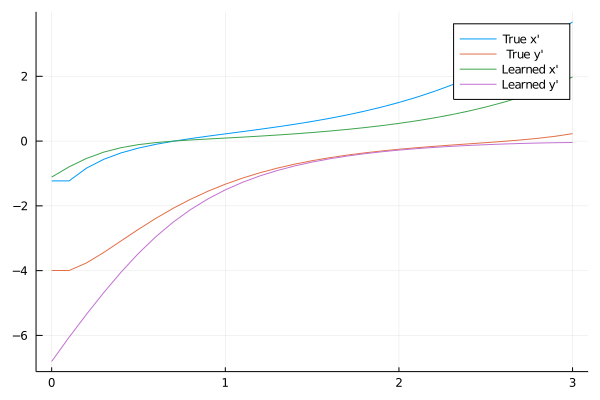

In [265]:
X = Array(solution(solution.t, Val{1}))

prob_nn2 = ODEProblem(dudt_, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())
DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

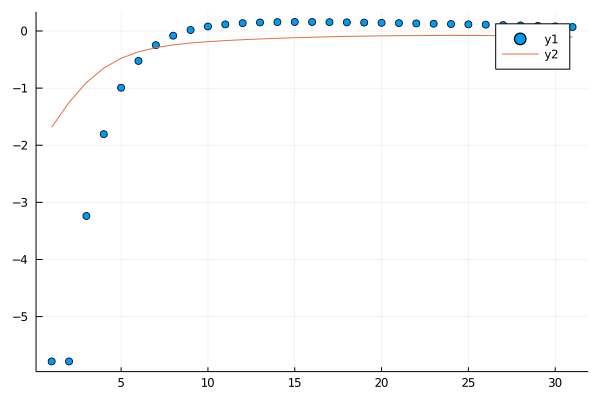

In [266]:
# Ideal data
L̄ = [-p_[2]*(X[1,:].*X[2,:])';p_[3]*(X[1,:].*X[2,:])']
# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(L̄'[:, 1])
plot!(L̂'[:, 1])

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [267]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the SINDy problem

In [268]:
opt = SR3()

# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [269]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 5
Active terms : 5
   Equation 1 : 3
   Equation 2 : 2
Overall error (L2-Norm) : 4.2193346
   Equation 1 : 3.2700293
   Equation 2 : 0.9493053
AICC :
   Equation 1 : 2.7992651
   Equation 2 : 5.096988

SR3{Float64,UnionAll}(0.5, 1.0, ProximalOperators.NormL1) converged after 6244 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = sin(u₁) * p₂ + cos(u₂) * p₁ + u₁ ^ 2 * p₃
du₂ = sin(u₂) * p₄ + p₅ * u₂



## Test on UODE derivative data

In [270]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 0.20723242
   Equation 1 : 0.11188534
   Equation 2 : 0.09534707
AICC :
   Equation 1 : 11.205567
   Equation 2 : 11.84537

SR3{Float64,UnionAll}(0.019905358527674864, 1.0, ProximalOperators.NormL1) did not converge after 10000 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₁ * u₂
du₂ = p₂ * u₁ * u₂



## Extract the parameter

In [271]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.86915183, 0.7729108]


## Define the ODE with the new identified unknown term

In [272]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [273]:
function dudt(du, u, p, t)
    # Add SINDy Term
    α, δ, β, γ = p
    z = unknown_eq(u, [β; γ], t)
    du[1] = α*u[1] + z[1]
    du[2] = -δ*u[2] + z[2]
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

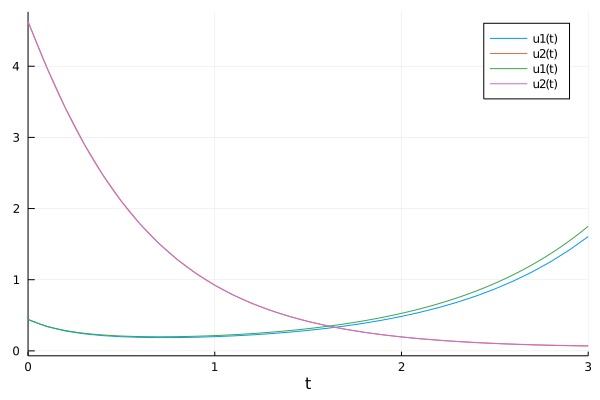

In [274]:
ps = [p_[[1,4]]; p̂]
approximate_prob = ODEProblem(dudt, u0, tspan, ps)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.01)

# Plot
plot(solution)
plot!(approximate_solution)

## Look at long term prediction

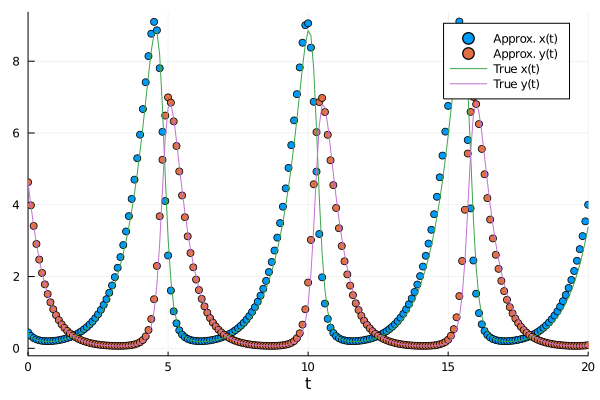

In [275]:
t_long = (0.0, 20.0)
approximate_prob = ODEProblem(dudt, u0, t_long, ps)
approximate_solution_long = solve(approximate_prob, Tsit5(), saveat = 0.1) # Using higher tolerances here results in exit of julia
scatter(approximate_solution_long, label = ["Approx. x(t)" "Approx. y(t)"])

true_prob = ODEProblem(LV, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = approximate_solution_long.t)
plot!(true_solution_long, label = ["True x(t)" "True y(t)"])